In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import acquire

### Acquire

Acquire the data for anonymized-corriculum-access. After doing some research, some experimentation of performing actions and watching the logs, we discovered what each of the fields represent. We then parse and name the fields accordingly.

In [2]:
# column names needed for exploration
colnames = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']

# pull dataframe from txt
df = pd.read_csv("anonymized-curriculum-access-07-2021.txt", 
                 sep="\s", 
                 header=None, 
                 names = colnames, 
                 usecols=[0, 2, 3, 4, 5])

# show first 5 rows of dataframe
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


### Prepare

In [3]:
# convert date col into datetime datatype
df.date = pd.to_datetime(df.date)

# set date as index
df = df.set_index(df.date)

# create a series called endpoint that counts # of logs per day
pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

<AxesSubplot:xlabel='date'>

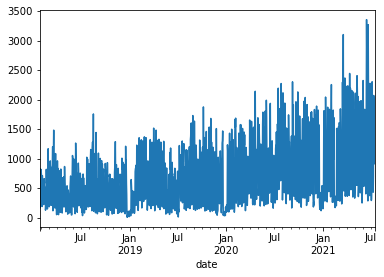

In [4]:
# plot to visualize the pages
pages.plot()

#### No need to split, normally data would be split here, that is not necessary at the moment since we are using a statistics based approach and are not at risk of oversampling
### Exponential Moving Average
SMA time series are much less noisy than the time series of the original data points. The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units.
Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.
The EMA function looks like this:
$EMA_{t}= \alpha * (t_{0} - EMA_{t-1}) + EMA_{t-1}$
Where:
 * M = Number of time periods, span of the window
 * $t_{0}$ = Latest value
 * $t-1$ = Previous value
 * $EMA_{t-1}$ = Exponential moving average of previous day.
 * The multiplier: $\alpha = \frac{2}{M+1}$
However, we will use the pandas ewm (Exponential Weighted functions) to compute our EMA. So we just need to define the following:
 * M = span argument = number of time periods. We will try 7 days, 14 days, and 30 days.
 * Notice how there are no missing values. ewm() will use as many values are available to compute the mean. So if the span is 7 days, but it is on the first day of data available, the EMA will equal the first value.

<AxesSubplot:xlabel='date'>

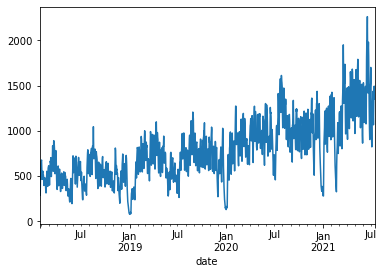

In [5]:
# The 7 day EMA (Exponential Moving Average)
ema_7d = pages.ewm(span = 7).mean()
ema_7d.plot()

<AxesSubplot:xlabel='date'>

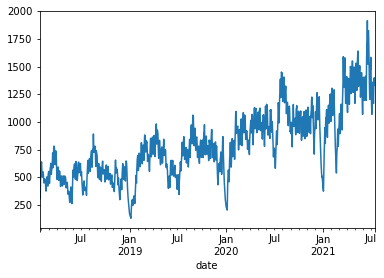

In [6]:
# The 14 day EMA (Exponential Moving Average)
ema_14d = pages.ewm(span = 14).mean()
ema_14d.plot()

<AxesSubplot:xlabel='date'>

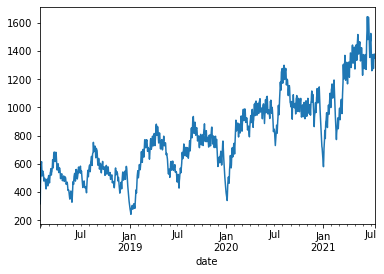

In [7]:
# The 30 day EMA (Exponential Moving Average)
ema_30d = pages.ewm(span = 30).mean()
ema_30d.plot()

<AxesSubplot:xlabel='date'>

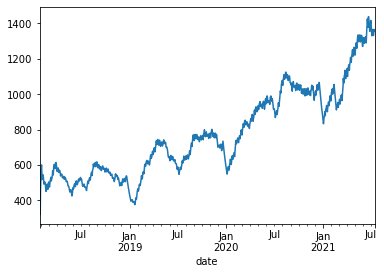

In [8]:
# The 90 day EMA (Exponential Moving Average)
ema_90d = pages.ewm(span = 90).mean()
ema_90d.plot()

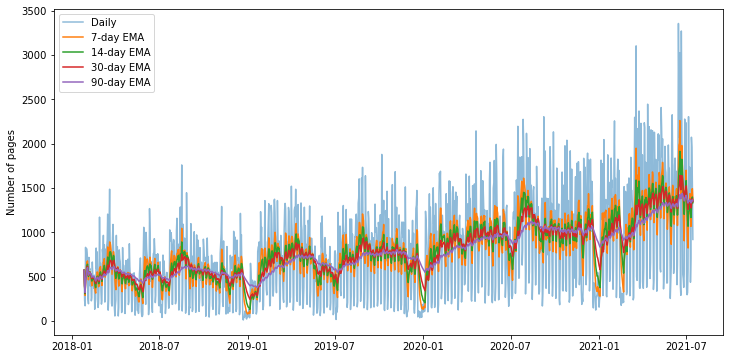

In [9]:
# Plot each of the above for comparison

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

### Bollinger Bands and %b
#### Bollinger Bands
 * a volatility indicator and commonly used in stock market trading.
 * Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.
#### Midband
 * The Exponential Moving Average
 * midband = train.ewm(span=30).mean()
#### Upper & Lower Band
 * UB/LB = Midband +/- stdev * K
 * stdev = train.ewm(span=30).std()
 * K = the number of standard deviations to go up and down from the EMA
#### %b, Percent Bandwidth
 * Shows where the last value sits in relation to the bands
 * $\%b = \frac{last-LB}{UB-LB}$
 * %b > 1 => point lies above UB
 * %b < 0 => point lies below LB
 * %b == .5 => point lies on the midband.
#### Bandwidth
 * The width of the bands
 * $Bandwidth = \frac{(UB-LB)}{Midband}$

In [10]:
# set span as number of days
span = 30

# midband is the Exponential Moving Average on pages
midband = pages.ewm(span=span).mean()
# show what midband would look like
midband.head(3)

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
Freq: D, Name: endpoint, dtype: float64

In [11]:
# compute Exponential Moving Standard Deviation on pages
std = pages.ewm(span=span).std()
std.head(3)

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
Freq: D, Name: endpoint, dtype: float64

In [12]:
# establish number of standard deviations from ema, (k)
k = 3

# create upper and lower band, ub and lb.
ub = midband + (std * k)
lb = midband - (std * k)

In [13]:
# see the upper bound - first 3
ub.head(3)

date
2018-01-26            NaN
2018-01-27    1120.791557
2018-01-28     956.773991
Freq: D, Name: endpoint, dtype: float64

In [14]:
# lower bound first 3
lb.head(3)

date
2018-01-26           NaN
2018-01-27   -330.191557
2018-01-28   -326.494835
Freq: D, Name: endpoint, dtype: float64

In [15]:
# concat pages, midband, ub, and lb to make a single df
my_df = pd.concat([pages, midband, ub, lb], axis=1)

# Name columns of bollinger band df
my_df.columns = ['pages','midband','ub','lb']
my_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


#### Plot the bands

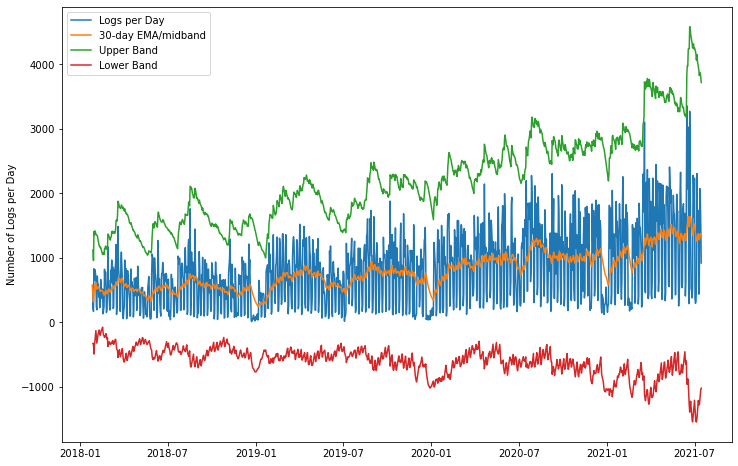

In [16]:
# creates subplot graph area for the different graphs
fig, ax = plt.subplots(figsize=(12,8))

# breaking down the graphs to include in the subplots
ax.plot(my_df.index, my_df.pages, label='Logs per Day')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of Logs per Day')

plt.show()


### Compute %b
$\%b = \frac{last-LB}{UB-LB}$
Each row/time period, will have a %b value that answers the question, where does this point sit with respect to the expected value when considering the values before it. For example, we could take the last value in train and manually compute %b:
last = current measurement of pages

In [17]:
my_df['pct_b'] = (my_df.pages - my_df.lb) / (my_df.ub - my_df.lb)
my_df.head(3)

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899


Now, where do we see anomalies? We will search for %b values > 1. We don't need to search for values < 0 because with this example, a low extreme is not something we are concerned about.

In [18]:
my_df[my_df.pct_b > 1]

,pages,midband,ub,lb,pct_b
date,,,,,


### Pull it all together! 
1. acquire
2. prep with user
3. compute features
 * compute midband
 * compute standard deviation
 * compute upper & lower band
 * create df with metrics
 * compute %b
 * add user_id to dataframe
4. Plot
5. search for anomalies

In [19]:
# Creating funtions to do everything above

def acquire(file_name, column_names):
    '''
    This function acquires a text file, 
    labels the columns as specifiied in the column_names list, and
    returns a pandas dataframe.
    '''
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user):
    '''
    This function takes in a dataframe, 
    limits it to a specific user, 
    converts date column to datetime datatype and sets it as index, and
    creates and returns a series containing total number of logs the user accessed per day,
    '''
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['endpoint'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    '''
    This function takes in a series, a span, a weight, and a user.
    Then creates bollinger bands, midband, upper band, and lower band, 
    then calculates the percent bandwidth of each day, finally
    returns a dataframe containing the information specific to a single user.
    '''
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev * weight
    lb = midband - stdev * weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    '''
    This function plots a bollinger bands graph of a specific user.
    '''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()
    
def find_anomalies(df, user, span, weight):
    '''
    This function combines, prep, compute_pct_b, and plt_bands functions, and 
    returns a dataframe of instances where the number of logs 
    is greater than the upper band.
    '''
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
#     plt_bands(my_df, user)
    return my_df[my_df.pct_b > 1]

#### Acquire

Test Acquire

In [20]:
# file being used
file_name = "anonymized-curriculum-access-07-2021.txt"

# columns to keep
column_names = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']

# create df from acquire
df = acquire(file_name, column_names)
# show the first 3 of the df created
df.head(3)

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61


Test Prep

In [21]:
# test prep with df created in previous cell, on a single user
user = 341
span = 30
weight = 3

anomalies = pd.DataFrame()
user_df = find_anomalies(df, user, span, weight)
anomalies = pd.concat([anomalies, user_df], axis=0)

In [22]:
anomalies

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,232.200343,-182.757078,1.095913,341
2020-02-18,3,0.193548,2.442380,-2.055283,1.123980,341
2020-03-10,4,0.305768,3.479509,-2.867973,1.082000,341
2020-04-21,109,7.250725,88.818626,-74.317176,1.123709,341
2020-07-13,52,6.283047,45.711487,-33.145393,1.079746,341
2020-10-03,11,0.991326,10.107234,-8.124582,1.048967,341
2020-10-25,10,0.873729,9.489350,-7.741892,1.029635,341
2021-02-09,10,0.659630,8.244463,-6.925203,1.115727,341


Loop through all users

In [23]:
span = 30
weight = 3.5

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

In [24]:
anomalies

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-01-29,44,3.623334,42.081344,-34.834677,1.024945,1
2019-07-08,101,8.248768,96.507472,-80.009936,1.025451,1
2018-10-15,9,0.581421,8.457414,-7.294571,1.034446,3
2019-01-09,4,0.262470,3.802115,-3.277175,1.027953,3
2019-04-06,2,0.129825,1.889712,-1.630061,1.031334,3
...,...,...,...,...,...,...
2021-06-02,72,10.456225,71.377304,-50.464854,1.005111,925
2021-06-29,32,3.881578,31.571606,-23.808449,1.007736,929
2021-06-11,44,5.582783,43.858655,-32.693089,1.001846,961


Explore the anomalies

In [25]:
# look at value counts for pages in anomalies
anomalies.pages.value_counts(sort = False)

1      56
2      40
3      85
4      87
5      62
       ..
179     1
192     1
198     1
272     1
343     1
Name: pages, Length: 105, dtype: int64

In [26]:
anomalies[anomalies.pages == 343]

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2021-06-21,343,22.370564,322.155049,-277.413921,1.034767,804


In [27]:
anomalies[anomalies.user_id == 804]

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2021-01-20,74,8.832557,73.838286,-56.173171,1.001244,804
2021-06-21,343,22.370564,322.155049,-277.413921,1.034767,804


In [28]:
df[df.user_id == 343]

,date,endpoint,user_id,cohort_id,source_ip
181813,2019-01-22,/,343,29.0,97.105.19.58
181831,2019-01-22,toc,343,29.0,97.105.19.58
181839,2019-01-22,html-css,343,29.0,97.105.19.58
181924,2019-01-22,appendix,343,29.0,97.105.19.58
181950,2019-01-22,html-css,343,29.0,97.105.19.58
...,...,...,...,...,...
271693,2019-05-24,jquery/events/mouse-events,343,29.0,97.105.19.58
272333,2019-05-27,/,343,29.0,72.181.110.80
272692,2019-05-28,javascript-i,343,29.0,72.181.110.80
272693,2019-05-28,javascript-i/mapbox-api,343,29.0,72.181.110.80


In [32]:
import acquire

### Bring in cohorts both datasets from SQL

In [33]:
# Bring in cohorts both datasets from SQL

sql_query = '''
SELECT * from cohorts
'''

In [34]:
df2 = acquire.get_sql_data('curriculum_logs', sql_query)

In [35]:
df2.head()

,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,1,Arches,#arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
1,2,Badlands,#badlands,2014-06-04,2014-08-22,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
2,3,Carlsbad,#carlsbad,2014-09-04,2014-11-05,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
3,4,Denali,#denali,2014-10-20,2015-01-18,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
4,5,Everglades,#everglades,2014-11-18,2015-02-24,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1


In [36]:
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [37]:
df_merge = df.merge(df2, left_on='cohort_id', right_on= 'id', how = 'left')

In [38]:
df_merge.head(3)

,date,endpoint,user_id,cohort_id,source_ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
1,2018-01-26,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0


In [39]:
df_merge = df_merge.drop(columns=['id', 'created_at', 'updated_at', 'deleted_at'])

In [40]:
df_merge.head()

,date,endpoint,user_id,cohort_id,source_ip,name,slack,start_date,end_date,program_id
0,2018-01-26,/,1,8.0,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,java-ii,1,8.0,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1.0
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2.0
